# Recursive Feature Elimination with Cross-Validation




https://heartbeat.fritz.ai/feature-ranking-with-recursive-feature-elimination-3e22db639208

### Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')
data = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


### Data cleaning and preparation


In [12]:
data.drop(['Ticket', 'PassengerId'], axis=1, inplace=True) #no use of ticket and passengerId

gender_mapper = {'male': 0, 'female': 1}                     #male and female
data['Sex'].replace(gender_mapper, inplace=True)               


data['Title'] = data['Name'].apply(lambda x: x.split(',')[1].strip().split(' ')[0])          #extracting titles from names
data['Title'] = [0 if x in ['Mr.', 'Miss.', 'Mrs.'] else 1 for x in data['Title']]
data = data.rename(columns={'Title': 'Title_Unusual'})
data.drop('Name', axis=1, inplace=True)


data['Cabin_Known'] = [0 if str(x) == 'nan' else 1 for x in data['Cabin']]
data.drop('Cabin', axis=1, inplace=True)

emb_dummies = pd.get_dummies(data['Embarked'], drop_first=True, prefix='Embarked')        #encoding of embarked
data = pd.concat([data, emb_dummies], axis=1)
data.drop('Embarked', axis=1, inplace=True)

data['Age'] = data['Age'].fillna(int(data['Age'].mean()))

data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Title_Unusual,Cabin_Known,Embarked_Q,Embarked_S
0,0,3,0,22.0,1,0,7.2500,0,0,0,1
1,1,1,1,38.0,1,0,71.2833,0,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,1,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,1,0,0,1
887,1,1,1,19.0,0,0,30.0000,0,1,0,1
888,0,3,1,29.0,1,2,23.4500,0,0,0,1
889,1,1,0,26.0,0,0,30.0000,0,1,0,0


### Remove correlated features¶

#CORRELATION BETWEEN FEATURES INDICATE THEY CONVEY THE SAME INFORMATION............. SO NO NEED TO KEEP BOTH 

IT WILL MAKE MAKE REDUDANCE FEATURES AND LEAD TO OVERFITTING

SO WE CAN ACTUALLY REMOVE THE FEATURES WHICH ARE CORRELATED

In [23]:
correlated_features = set()
correlation_matrix = data.drop('Survived', axis=1).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

correlated_features                                 # this set is empty indicated no features are tightly correlated

set()

### Running RFECV¶


In [24]:
X = data.drop('Survived', axis=1)
target = data['Survived']

rfc = RandomForestClassifier(random_state=101)
rfecv = RFECV(estimator=rfc, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(X, target)

print('Optimal number of features: {}'.format(rfecv.n_features_))


Optimal number of features: 4


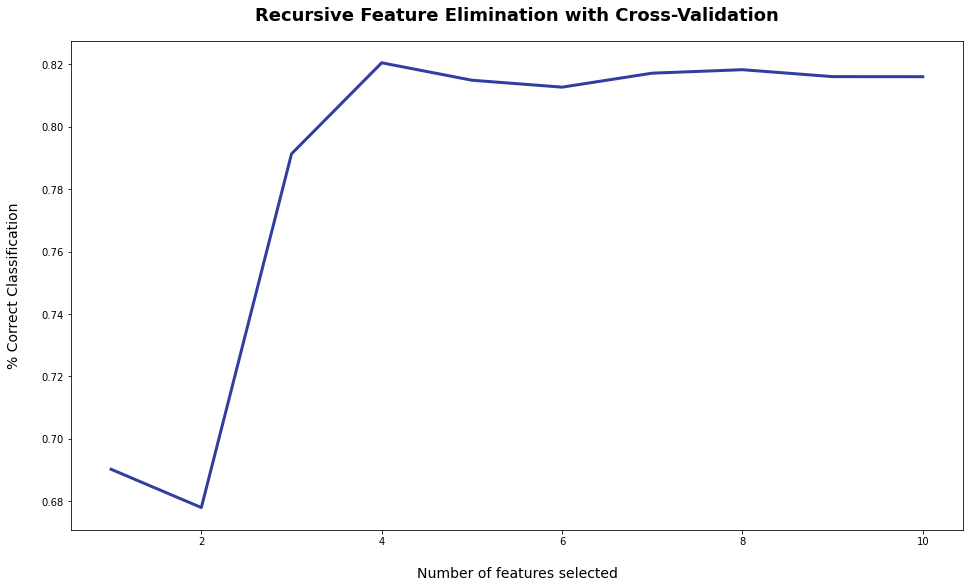

In [25]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [26]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[3 4 6 7 8 9]


In [21]:
rfecv.estimator_.feature_importances_


array([0.09550623, 0.27979401, 0.28835754, 0.33634222])

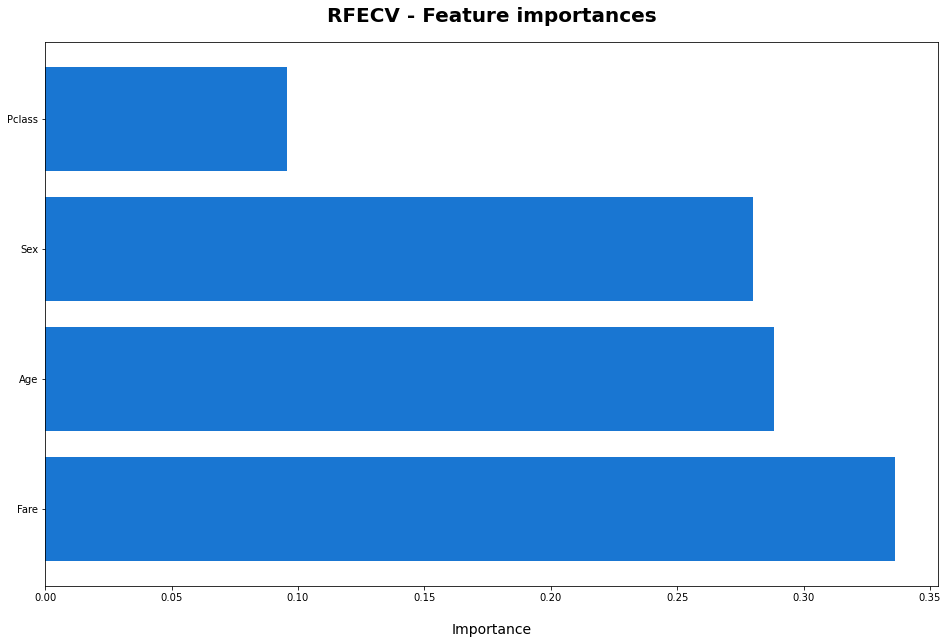

In [27]:
dset = pd.DataFrame()
dset['attr'] = X.columns
dset['importance'] = rfecv.estimator_.feature_importances_
dset = dset.sort_values(by='importance', ascending=False)

plt.figure(figsize=(16, 10))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()